In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import lightgbm as lgb




In [29]:
df=pd.read_csv('DbSalesModified.csv')
df.head()

,IdSale,SaleNumber,IdCompany,CreateDate,TotalSale,IdWarehouse,IdBranchCompany,IdDocument,IdSaleDetails,IdProduct,Quantity,UnitPrice,NameProduct
0,1814782,2,150,2020-02-03,5500.0,258,230,8,3082205,185083,1,5500,Mogolla centegranos 12 unidades
1,1814972,3,150,2020-02-03,15000.0,258,230,8,3082513,184920,1,15500,Aceite de naranja 250ml
2,1815208,4,150,2020-02-03,1300.0,258,230,8,3082901,185087,1,1300,Galleta integral
3,1815420,5,150,2020-02-03,13200.0,258,230,8,3083224,185069,1,11500,Boldex 16 capsulas
4,1815420,5,150,2020-02-03,13200.0,258,230,8,3083225,185089,1,1700,Chicharrines


In [30]:
df.shape

(38229, 13)

# Preprocesamiento

In [31]:
df.drop(columns=['IdSale','SaleNumber','IdDocument','IdSaleDetails','NameProduct','TotalSale'], inplace=True)

In [32]:
df.isna().sum()


IdCompany          0
CreateDate         0
IdWarehouse        0
IdBranchCompany    0
IdProduct          0
Quantity           0
UnitPrice          0
dtype: int64

In [33]:
df_daily = (
    df.groupby([
        "CreateDate",
        "IdCompany",
        "IdBranchCompany",
        "IdWarehouse",
        "IdProduct"
    ], as_index=False)
    .agg({
        "Quantity": "sum",
        "UnitPrice": "mean"
    })
)


In [34]:
df_daily.head()


,CreateDate,IdCompany,IdBranchCompany,IdWarehouse,IdProduct,Quantity,UnitPrice
0,2020-02-03,150,230,258,184881,2,1200.0
1,2020-02-03,150,230,258,184883,6,600.0
2,2020-02-03,150,230,258,184885,2,800.0
3,2020-02-03,150,230,258,184901,1,3000.0
4,2020-02-03,150,230,258,184920,1,15500.0


## Modificacion fecha

In [35]:
df_daily["CreateDate"] = pd.to_datetime(df_daily["CreateDate"])

df_daily["day"]=df_daily["CreateDate"].dt.day
df_daily["month"]=df_daily["CreateDate"].dt.month
df_daily["year"]=df_daily["CreateDate"].dt.year
df_daily["dayofweek"]=df_daily["CreateDate"].dt.dayofweek
df_daily["weekofyear"]=df_daily["CreateDate"].dt.isocalendar().week

## filtro df_daily >1

In [36]:
df_daily = df_daily[df_daily["UnitPrice"] > 1]


## Transformaciones

In [37]:
df_daily["Quantity_log"] = np.log1p(df_daily["Quantity"])
df_daily["UnitPrice_log"] = np.log1p(df_daily["UnitPrice"])

In [38]:
df_daily.to_csv('DbSalesDaily.csv', index=False)

In [39]:
df_daily.head()

,CreateDate,IdCompany,IdBranchCompany,IdWarehouse,IdProduct,Quantity,UnitPrice,day,month,year,dayofweek,weekofyear,Quantity_log,UnitPrice_log
0,2020-02-03,150,230,258,184881,2,1200.0,3,2,2020,0,6,1.098612,7.090910
1,2020-02-03,150,230,258,184883,6,600.0,3,2,2020,0,6,1.945910,6.398595
2,2020-02-03,150,230,258,184885,2,800.0,3,2,2020,0,6,1.098612,6.685861
3,2020-02-03,150,230,258,184901,1,3000.0,3,2,2020,0,6,0.693147,8.006701
4,2020-02-03,150,230,258,184920,1,15500.0,3,2,2020,0,6,0.693147,9.648660


# Creacion Lags

In [40]:
group_cols = [
    "IdCompany",
    "IdBranchCompany",
    "IdWarehouse",
    "IdProduct"
]

df_daily = df_daily.sort_values("CreateDate")

df_daily["lag_1"] = (
    df_daily
    .groupby(group_cols)["Quantity_log"]
    .shift(1)
)

df_daily["lag_7"] = (
    df_daily
    .groupby(group_cols)["Quantity_log"]
    .shift(7)
)

df_daily["lag_30"] = (
    df_daily
    .groupby(group_cols)["Quantity_log"]
    .shift(30)
)


In [41]:
df_daily = df_daily.dropna()


In [42]:
df_daily[
    ["CreateDate", "Quantity_log", "lag_1", "lag_7"]
].head(15)


,CreateDate,Quantity_log,lag_1,lag_7
714,2020-03-24,1.609438,0.693147,0.693147
726,2020-03-31,1.386294,1.609438,1.098612
731,2020-04-01,1.386294,1.386294,1.098612
751,2020-04-14,1.609438,1.386294,1.098612
835,2020-04-27,1.386294,1.609438,2.197225
847,2020-04-28,1.791759,2.079442,1.386294
897,2020-04-30,0.693147,1.386294,1.098612
913,2020-05-01,0.693147,0.693147,0.693147
938,2020-05-02,0.693147,0.693147,1.609438
960,2020-05-04,1.609438,1.791759,1.945910


# Categoricas


In [43]:
df_daily = df_daily.sort_values("CreateDate")

split_date = "2024-01-01"

train = df_daily[df_daily["CreateDate"] < split_date]
test  = df_daily [df_daily["CreateDate"] >= split_date]


In [44]:
target = "Quantity_log"


In [45]:
global_mean = train[target].mean()

In [46]:
def target_encode(train, test, col, target, global_mean):
    
    means = train.groupby(col)[target].mean()
    
    train[col + "_te"] = train[col].map(means)
    
    test[col + "_te"] = test[col].map(means)
    
    train[col + "_te"].fillna(global_mean, inplace=True)
    test[col + "_te"].fillna(global_mean, inplace=True)
    
    return train, test


categorical_cols = [
    "IdCompany",
    "IdBranchCompany",
    "IdWarehouse",
    "IdProduct"
]

for col in categorical_cols:
    train, test = target_encode(
        train,
        test,
        col,
        target,
        global_mean
    )


C:\Users\Johan Suarez\AppData\Local\Temp\ipykernel_22784\403997912.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col + "_te"] = train[col].map(means)
C:\Users\Johan Suarez\AppData\Local\Temp\ipykernel_22784\403997912.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col + "_te"] = test[col].map(means)
C:\Users\Johan Suarez\AppData\Local\Temp\ipykernel_22784\403997912.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

In [47]:
df_daily.head() 

,CreateDate,IdCompany,IdBranchCompany,IdWarehouse,IdProduct,Quantity,UnitPrice,day,month,year,dayofweek,weekofyear,Quantity_log,UnitPrice_log,lag_1,lag_7,lag_30
714,2020-03-24,150,230,258,185089,4,1700.0,24,3,2020,1,13,1.609438,7.438972,0.693147,0.693147,1.386294
726,2020-03-31,150,230,258,185089,3,1700.0,31,3,2020,1,14,1.386294,7.438972,1.609438,1.098612,1.098612
731,2020-04-01,150,230,258,185089,3,1700.0,1,4,2020,2,14,1.386294,7.438972,1.386294,1.098612,1.609438
751,2020-04-14,150,230,258,185089,4,1700.0,14,4,2020,1,16,1.609438,7.438972,1.386294,1.098612,1.386294
835,2020-04-27,150,230,258,185089,3,1700.0,27,4,2020,0,18,1.386294,7.438972,1.609438,2.197225,0.693147


# Modelo LightGBM

In [48]:
features = [
    # temporales
    "day", "month", "year", "dayofweek", "weekofyear",

    # precio
    "UnitPrice_log",

    # lags
    "lag_1", "lag_7", "lag_30",

    # target encoding
    "IdCompany_te",
    "IdBranchCompany_te",
    "IdWarehouse_te",
    "IdProduct_te"
]


In [49]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


In [60]:
y_train

714      1.609438
726      1.386294
731      1.386294
751      1.609438
835      1.386294
           ...   
24643    0.693147
24642    0.693147
24639    0.693147
24638    0.693147
24637    0.693147
Name: Quantity_log, Length: 10828, dtype: float64

In [50]:
lgb_model = lgb.LGBMRegressor(
n_estimators=1000,      
    learning_rate=0.03,     
    num_leaves=31,          
    max_depth=8,            
    random_state=42,
    importance_type='gain'
)

lgb_model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 525
[LightGBM] [Info] Number of data points in the train set: 10828, number of used features: 10
[LightGBM] [Info] Start training from score 0.943718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LGBMRegressor(importance_type='gain', learning_rate=0.03, max_depth=8,
              n_estimators=1000, random_state=42)

In [51]:
y_pred_train = lgb_model.predict(X_train)
y_pred_test  = lgb_model.predict(X_test)


In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def regression_metrics(y_true, y_pred, name=""):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    print(f"{name}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")
    print("-"*30)


In [55]:
regression_metrics(y_train, y_pred_train, "TRAIN")
regression_metrics(y_test,  y_pred_test,  "TEST")


TRAIN
RMSE: 0.2384
MAE : 0.1561
R²  : 0.8251
------------------------------
TEST
RMSE: 0.2845
MAE : 0.1551
R²  : 0.3135
------------------------------


In [54]:
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred_test)

rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
mae_real  = mean_absolute_error(y_test_real, y_pred_real)

print("Escala real:")
print(f"RMSE: {rmse_real:.2f}")
print(f"MAE : {mae_real:.2f}")


Escala real:
RMSE: 1.65
MAE : 0.55


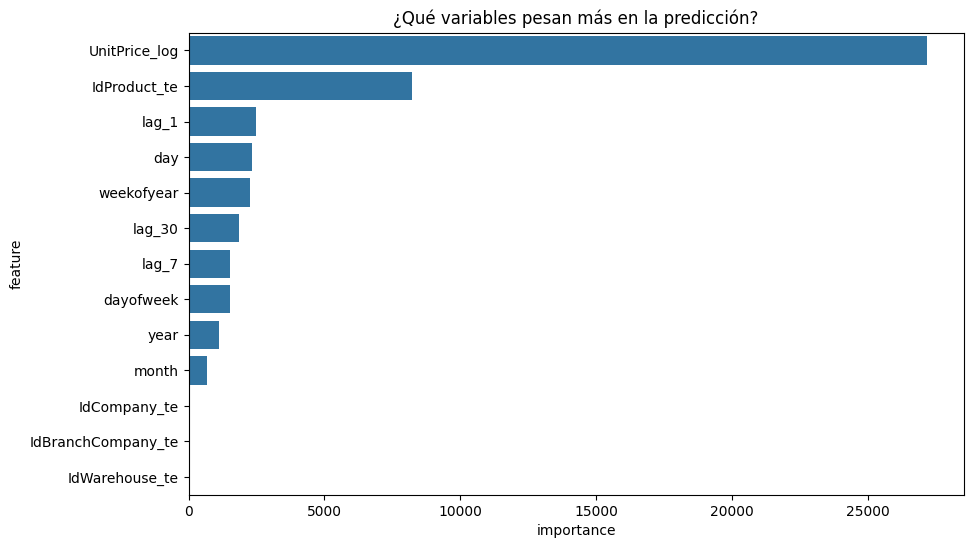

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener importancia
importance = pd.DataFrame({
    'feature': features,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance)
plt.title('¿Qué variables pesan más en la predicción?')
plt.show()